In [13]:
# for reloading the editable module
%load_ext autoreload
%autoreload 2

# Register your package and submodules
# %aimport probabilistic_load_forecast
# %aimport probabilistic_load_forecast.application.services
# %aimport probabilistic_load_forecast.adapters.db
# %aimport probabilistic_load_forecast.adapters.cds
# %aimport probabilistic_load_forecast.adapters.entsoe
# %aimport probabilistic_load_forecast.domain.model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
from pathlib import Path
from dotenv import load_dotenv
from datetime import timezone, datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy import stats

In [15]:
# Import services and domain models
from probabilistic_load_forecast.application.services import (
    GetActualLoadData,
    GetERA5DataFromDB,
    GetERA5DataFromCDSStore,
    CreateCDSCountryAverages,
)

from probabilistic_load_forecast.domain.model import (
    LoadMeasurement,
    LoadTimeseries,
    Era5Timeseries,
)

# Import adapters for data access
from probabilistic_load_forecast.adapters.db import (
    EntsoePostgreRepository,
    Era5PostgreRepository,
)

from probabilistic_load_forecast.adapters.entsoe import (
    EntsoeAPIClient,
    EntsoeFetcher,
    XmlLoadMapper,
    EntsoeDataProvider,
)

from probabilistic_load_forecast.adapters.cds import (
    CDSAPIClient,
    CDSConfig,
    CDSDataProvider,
)

# Import configuration
from probabilistic_load_forecast import config

# Load environment variables

if not load_dotenv(Path("../..") / ".env"):
    raise FileNotFoundError("Could not open the .env file.")

In [16]:
# Initialize database repositories
try:
    # Load data repository
    load_repo = EntsoePostgreRepository(config.get_postgre_uri())

    # ERA5 weather data repository
    era5_repo = Era5PostgreRepository(config.get_postgre_uri())

    print("Database repositories initialized successfully")
except Exception as e:
    print(f"Error initializing repositories: {e}")
    print("Make sure your .env file contains the correct database credentials")

Database repositories initialized successfully


In [17]:
# Initialize services
get_load_data = GetActualLoadData(load_repo)
get_era5_data = GetERA5DataFromDB(era5_repo)

print("Services initialized successfully")

Services initialized successfully


In [18]:
start = datetime(2018, 10, 1, 0, 0, tzinfo=timezone.utc)
end = datetime(2025, 10, 10, 0, 0, tzinfo=timezone.utc)

era5_variables = ["t2m", "u10", "v10", "ssrd", "tp"]
era5_data = get_era5_data(
    variables=era5_variables, country_code="AT", start=start, end=end
)
actual_load_ts = get_load_data(start, end)

In [42]:
# Setting sime themes
sns.set_theme(style="whitegrid")

season_colors = {
    'Winter': '#031730',  
    'Spring': '#479003',
    'Summer': '#61bf9a', 
    'Autumn': '#fe8b4c'
}

# Amalysis of the Actual Total Load Data

In [20]:
actual_load_ts.data.describe()

,actual_load_mw
count,246012.000000
mean,6931.784364
std,1342.215493
min,4009.000000
25%,5858.000000
50%,6873.000000
75%,7884.000000
max,10818.000000


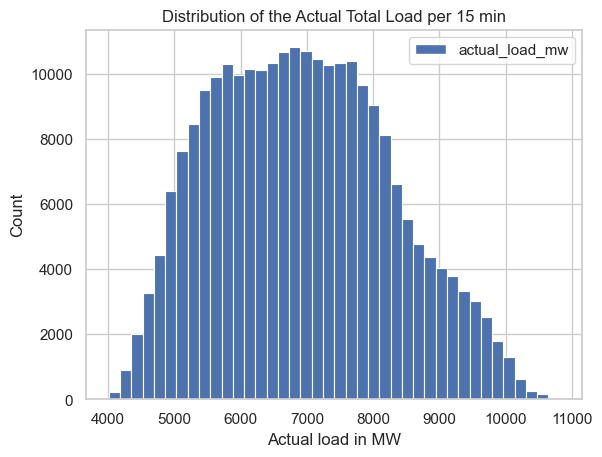

In [ ]:
ax = sns.histplot(data=actual_load_ts.data, alpha=1.0, bins=40)
ax.set_title("Distribution of the Actual Total Load per 15 min")
ax.set_xlabel("Actual Total Load (MW)");

The overall shape of the distribution seems approximately symmetric arount the mean of ~7000 MW per 15 min. The most values cluster between 6000 and 8000 MW.

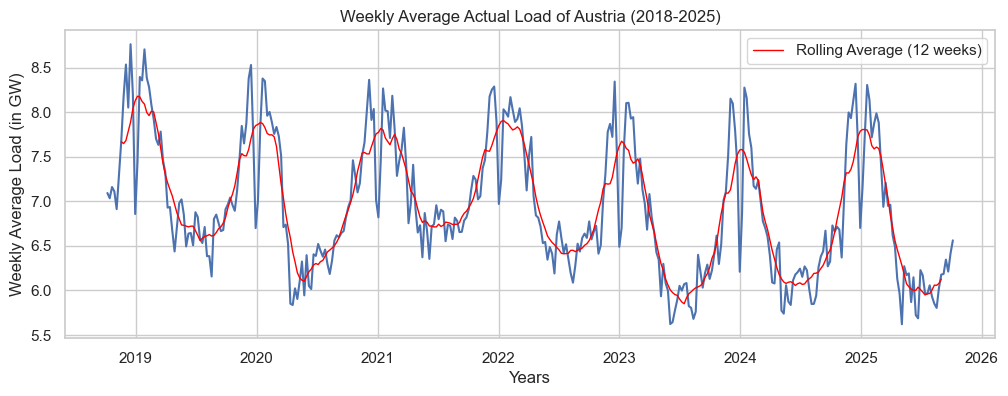

In [ ]:
temp_df = actual_load_ts.data.reset_index()
temp_df["period"] = temp_df["period"].dt.to_timestamp()
temp_df_weekly = temp_df.resample("W", on="period").mean().reset_index()
temp_df_weekly.drop(index=temp_df_weekly.index[-1], inplace=True)

temp_df_gw = temp_df_weekly.copy()
temp_df_gw["actual_load_gw"] = temp_df_weekly["actual_load_mw"] / 1000
plt.figure(figsize=(12, 4))

ax = sns.lineplot(
    data=temp_df_gw,
    x="period",
    y="actual_load_gw",
)

ax.set_ylabel("Weekly Average Load (in GW)")
ax.set_xlabel("Years")
ax.set_title("Weekly Average Actual Total Load of Austria (2018-2025)")

load_rolling_avg = temp_df_gw["actual_load_gw"].rolling(window=12, center=True).mean()
ax.plot(
    temp_df_gw["period"],
    load_rolling_avg,
    color="red",
    lw=1,
    label="Rolling Average (12 weeks)",
)

ax.legend();

In this graph the influence of the corona pandemic from 2020, is quite distinctive: A clear drop in the actual total load that might be coupled to the reduction of industrial production facilites or other business sectors facing less productivity in the lockdowns.

Summers after 2022 seem to have lower total load levels in the summer. This could reflect structural changes such as energy efficiency, demand-side changes or increased behind-the-meter PV, but additional generation data would be needed to confirm this.

Overall a strong seasonal effect is apparent in the data reflecting different load patterns in summer, winter, etc.

# Seasonality of the acutal total load

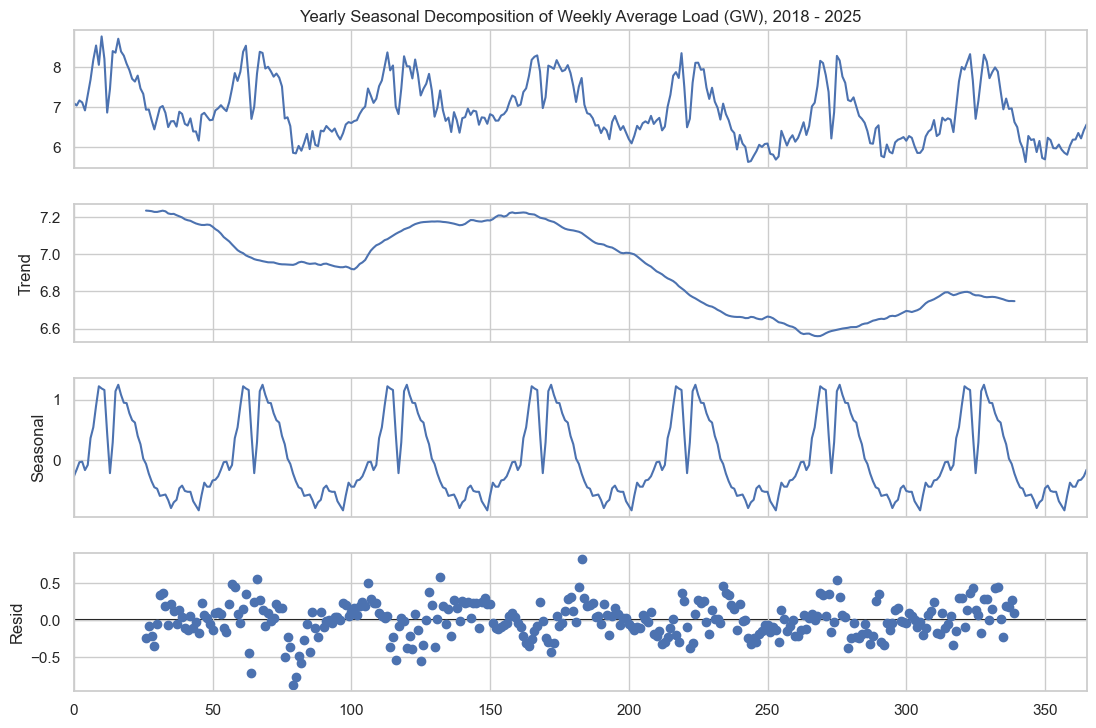

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(temp_df_gw["actual_load_gw"], model="additive", period=52)
fig = result.plot()
fig.set_size_inches(12, 8)
axes = fig.get_axes()
axes[0].set_title(
    "Yearly Seasonal Decomposition of Weekly Average Load (GW), 2018 - 2025"
);

There is several information in plot. The yearly seasonality of the actual total load data is quite pronounced as there is a yearly reoccuring rise of load in the winter season marked by distinctive drop in the end of the years around the holidays in december, which is further inspected in the graph below.

The seasonality of the plot seems to be relatively stable in the range of +1 to -1 GW.

The overall trend seems to include a drop during the corona pandemic followd by a short rise in load in the two consecutive years ending in a decline of total load to around ~4.5 GW toward the end of the observation period. 

The randomly scattered residual component with no visible persistent structure suggests that the model did effectively capture the systematic patterns in the actual total load timeseries.

In [24]:
df_actual_load_daily = temp_df.resample("D", on="period").mean().copy()
df_actual_load_daily["actual_load_gw"] = df_actual_load_daily["actual_load_mw"] / 1000
df_window = df_actual_load_daily[
    (df_actual_load_daily.index.month == 12) | (df_actual_load_daily.index.month == 1)
].copy()
df_window["seasonal_day"] = (
    (df_window.index.month == 12) * (df_window.index.dayofyear - 334)
) + (  # Dec 1 -> 1
    (df_window.index.month == 1) * (df_window.index.dayofyear + 31)
)  # Jan 1 -> 32

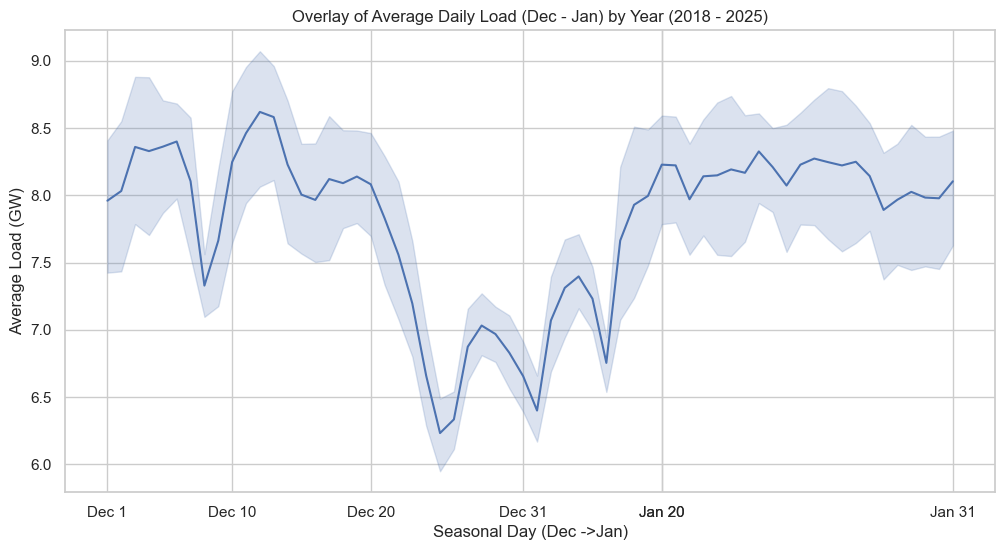

In [25]:
import matplotlib.dates as mdates

plt.figure(figsize=(12, 6))
ax = sns.lineplot(data=df_window, x="seasonal_day", y="actual_load_gw")
plt.title("Overlay of Average Daily Load (Dec - Jan) by Year (2018 - 2025)")
plt.xlabel("Seasonal Day (Dec -> Jan)")
plt.ylabel("Average Load (GW)")

ax.set_xticks([1, 10, 20, 31, 41, 41, 62])
ax.set_xticklabels(
    ["Dec 1", "Dec 10", "Dec 20", "Dec 31", "Jan 10", "Jan 20", "Jan 31"]
)
ax.set_xlabel("Seasonal Day (Dec ->Jan)");

We can observe the daily total load follows a consistent yearly pattern, showing a distinct decline during the holidays period like Christmas Day (25.12), Stefanitag (26.12) and New Year’s Day (01.01). This hints that holidays can be viable features when trying to forecast the actual total load.

# Weekly seasonal pattern

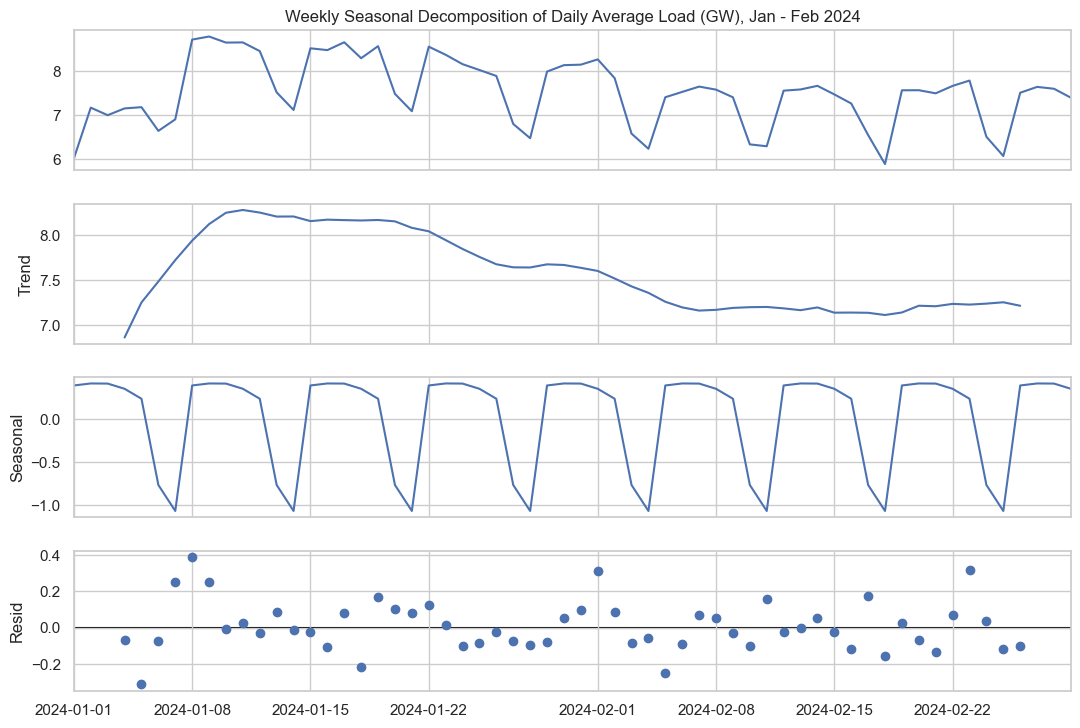

In [26]:
result = seasonal_decompose(
    df_actual_load_daily["2024-1":"2024-2"]["actual_load_gw"],
    model="additive",
    period=7,
)
fig = result.plot()
fig.set_size_inches(12, 8)
axes = fig.get_axes()
axes[0].set_title(
    "Weekly Seasonal Decomposition of Daily Average Load (GW), Jan - Feb 2024"
);

The dayli load data exhibits a distinct weekly seasonal pattern characterized by a steep decline during weekends. Load levels drop on staturday reaching it's lowest point on sunday. This behavior might be related to decreased industrial and commercial activity over the weekend as many manifacturing and service sectors either operate at a reduced capacity on saturday or close entirely on sunday.

# Daily Pattern

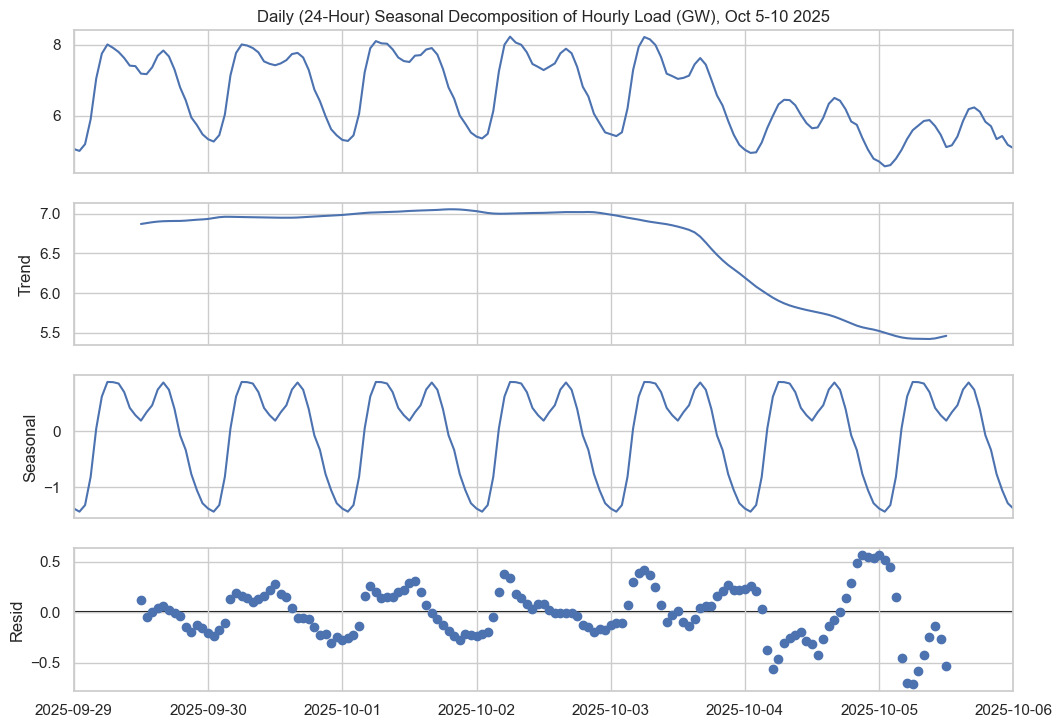

In [27]:
df_hourly = temp_df.resample("h", on="period").mean().copy()

result = seasonal_decompose(
    x=df_hourly["2025-09-29 00:00:00":"2025-10-06 00:00:00"]["actual_load_mw"] / 1000,
    model="additive",
    period=24,
)
fig = result.plot()
fig.set_size_inches(12, 8)
axes = fig.get_axes()
axes[0].set_title(
    "Daily (24-Hour) Seasonal Decomposition of Hourly Load (GW), Oct 5-10 2025"
);

The daily seasonal components in the graph above clearly indicate a seasonal pattern during the day which includes a sharp rise of load in the morning hours followed by a local minima at 12:00 after which the load rises again around the evining before declining overnight.

Furthermore there an overall weekly trend is observable which lines up perfectly with the previous made discovery of the weekly seasonal pattern which states that the load drops during the weekend.

# Hourly 

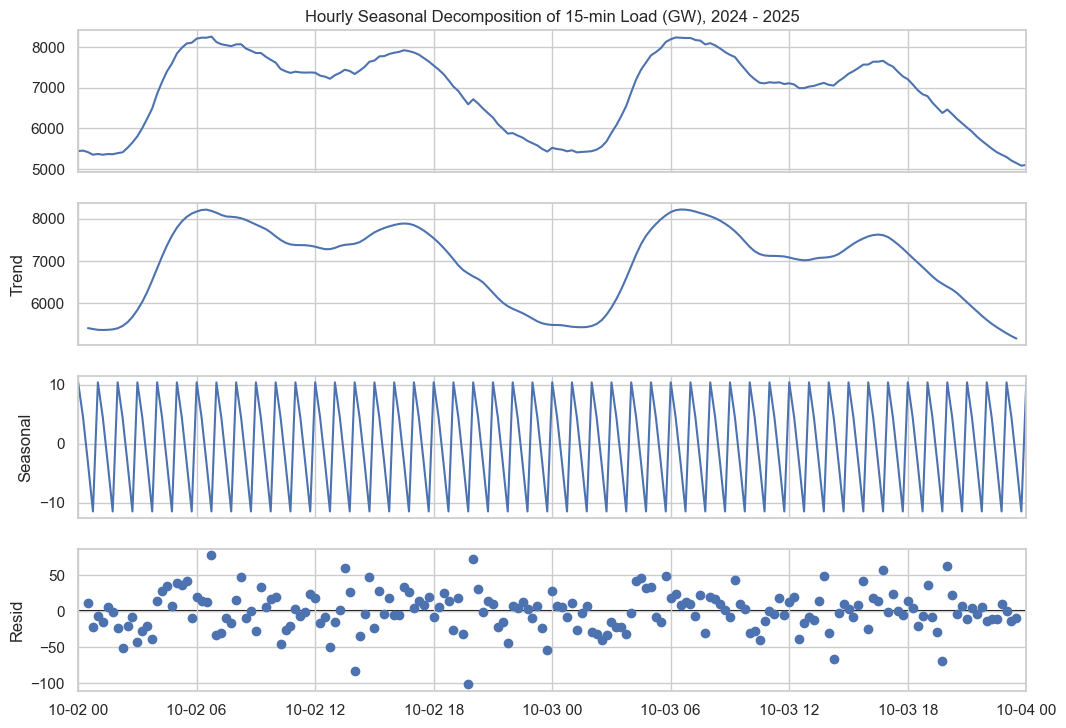

In [28]:
df_sample_actual_load = temp_df.set_index(keys="period")
result = seasonal_decompose(
    x=df_sample_actual_load["2025-10-2 00:00:00":"2025-10-4 00:00:00"][
        "actual_load_mw"
    ],
    model="additive",
    period=4,
)
fig = result.plot()
fig.set_size_inches(12, 8)
axes = fig.get_axes()
axes[0].set_title("Hourly Seasonal Decomposition of 15-min Load (GW), 2024 - 2025");

Here the intraday load pattern resembles the information seen in the last plot, the daily load increases in the morning hours around 06:00 decline to a local minima at 12:00 and peak again at 17:00 before finally declining overnight. The seasonal inter-hourly pattern might stem from grid optimization and varies for different dates, so it is not further investigated here.

# Auto Regression

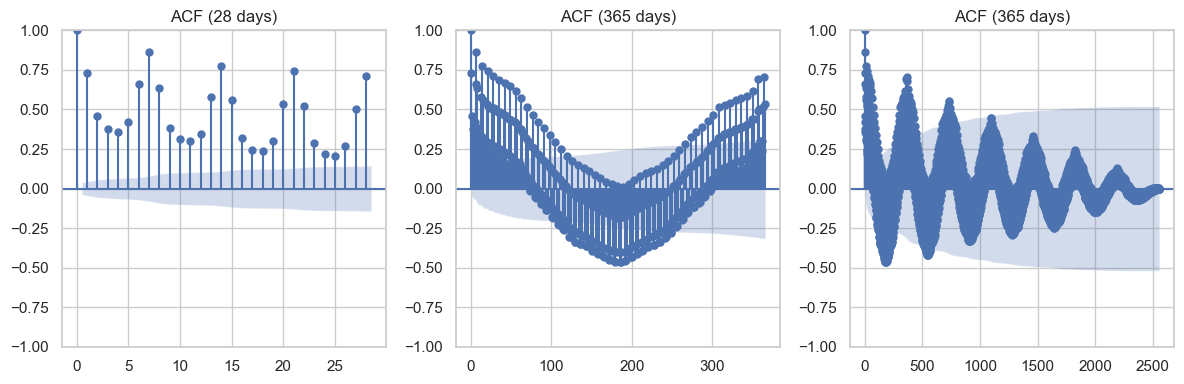

In [29]:
from statsmodels.graphics.tsaplots import plot_acf

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

plot_acf(df_actual_load_daily["actual_load_mw"], lags=28, ax=axes[0])
axes[0].set_title("ACF (28 days)")


plot_acf(df_actual_load_daily["actual_load_mw"], lags=365, ax=axes[1])
axes[1].set_title("ACF (365 days)")


plot_acf(df_actual_load_daily["actual_load_mw"], lags=365 * 7, ax=axes[2])
axes[2].set_title("ACF (365 days)")

plt.tight_layout()
plt.show()

Weekly:
The data indicates that there is a autocorrelation to the lagged values of the load at a lag-level around 7 which confirmes the previosly identified weekly seasonal pattern.

Yearly:
The data seems to be correlated with it lagged values reaching a low during a lag of ~ 180 and than rising again until becoming positive again at a lag of 365 which resembles a clear indicator for a strong yearly seasonality.

# Is the time series stationary?

 **ADF Test**

 * $H_0$: The series has a unit root (non-stationary).
 * $H_1$: The series is stationary.

In [30]:
from statsmodels.tsa.stattools import adfuller

adfuller(actual_load_ts.data["actual_load_mw"])

(np.float64(-9.934864955877517),
 np.float64(2.7607698284022715e-17),
 85,
 245926,
 {'1%': np.float64(-3.4303765907966524),
  '5%': np.float64(-2.8615517527923737),
  '10%': np.float64(-2.56677625558673)},
 np.float64(2689528.638370933))

**ADF Statistic:** -9.94
* **p-value:** 2.7×10⁻¹⁷
* **Critical Values:**

   * 1%: -3.43
   * 5%: -2.86
   * 10%: -2.57

**Decision:** Reject $H_0$

**Interpretation:** The series is stationary in trend, although seasonality is present.

# Analysis of the Temperature at 2 meters

Description: 
	
Temperature of air at 2m above the surface of land, sea or in-land waters. 2m temperature is calculated by interpolating between the lowest model level and the Earth's surface, taking account of the atmospheric conditions. Temperature measured in kelvin can be converted to degrees Celsius (°C) by subtracting 273.15.

Source: https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land?tab=overview


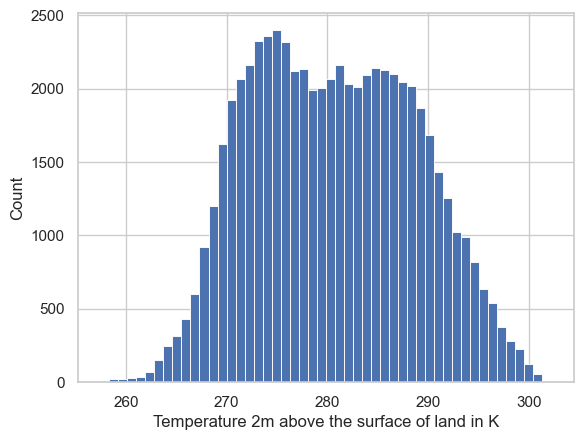

In [31]:
ax = sns.histplot(data=era5_data["t2m"], legend=False, alpha=1.0, bins=50)

ax.set_xlabel("Temperature 2m above the surface of land in K");

# Analysis of the Solar Radiation Downwards

Description: 

	
Amount of solar radiation (also known as shortwave radiation) reaching the surface of the Earth. This variable comprises both direct and diffuse solar radiation. Radiation from the Sun (solar, or shortwave, radiation) is partly reflected back to space by clouds and particles in the atmosphere (aerosols) and some of it is absorbed. The rest is incident on the Earth's surface (represented by this variable). To a reasonably good approximation, this variable is the model equivalent of what would be measured by a pyranometer (an instrument used for measuring solar radiation) at the surface. However, care should be taken when comparing model variables with observations, because observations are often local to a particular point in space and time, rather than representing averages over a model grid box and model time step. This variable is accumulated from the beginning of the forecast time to the end of the forecast step. The units are joules per square metre (J m^-2). To convert to watts per square metre (W m^-2), the accumulated values should be divided by the accumulation period expressed in seconds. The ECMWF convention for vertical fluxes is positive downwards.

Source: https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land?tab=overview

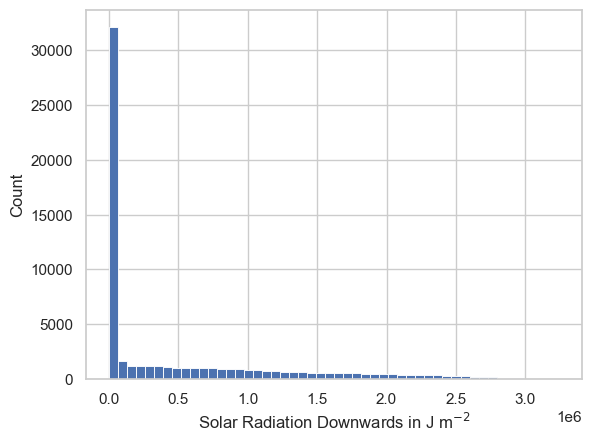

In [32]:
ax = sns.histplot(
    data=era5_data["ssrd"],
    legend=False,
    log_scale=(False, False),
    alpha=1.0,
    bins=50,
)

ax.set_xlabel("Solar Radiation Downwards in J m$^{-2}$");

The distribution seems failry right skewed, indicating that the most hours receive comparably small amounts of solar energy per square meter. 

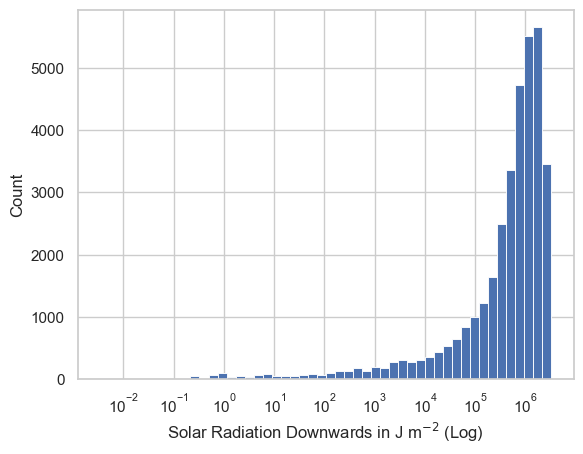

In [33]:
ax = sns.histplot(
    data=era5_data["ssrd"], legend=False, log_scale=(True, False), alpha=1.0, bins=50
)

ax.set_xlabel("Solar Radiation Downwards in J m$^{-2}$ (Log)");

After excluding the 0 values one can see that the must values are in the range of $10^{5}$ to $10^{6}$. 

# Analysis of the Total Precipitation

Description:

Accumulated liquid and frozen water, including rain and snow, that falls to the Earth's surface. It is the sum of large-scale precipitation (that precipitation which is generated by large-scale weather patterns, such as troughs and cold fronts) and convective precipitation (generated by convection which occurs when air at lower levels in the atmosphere is warmer and less dense than the air above, so it rises). Precipitation variables do not include fog, dew or the precipitation that evaporates in the atmosphere before it lands at the surface of the Earth. This variable is accumulated from the beginning of the forecast time to the end of the forecast step. The units of precipitation are depth in metres. It is the depth the water would have if it were spread evenly over the grid box. Care should be taken when comparing model variables with observations, because observations are often local to a particular point in space and time, rather than representing averages over a model grid box and model time step.

Source: https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land?tab=overview

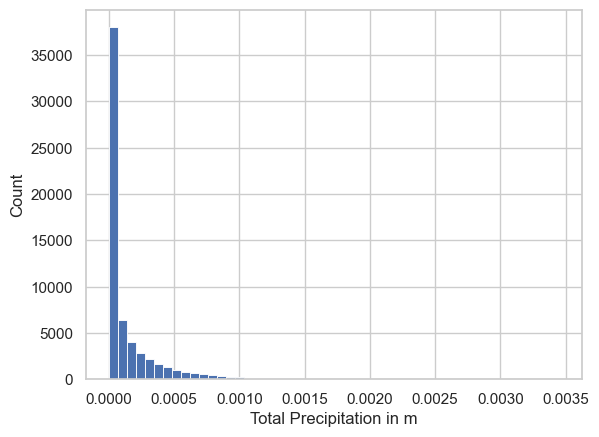

In [34]:
ax = sns.histplot(
    data=era5_data["tp"], legend=False, log_scale=(False, False), alpha=1.0, bins=50
)

ax.set_xlabel("Total Precipitation in m");

For most hours, there seems to be little to no total precipitation.

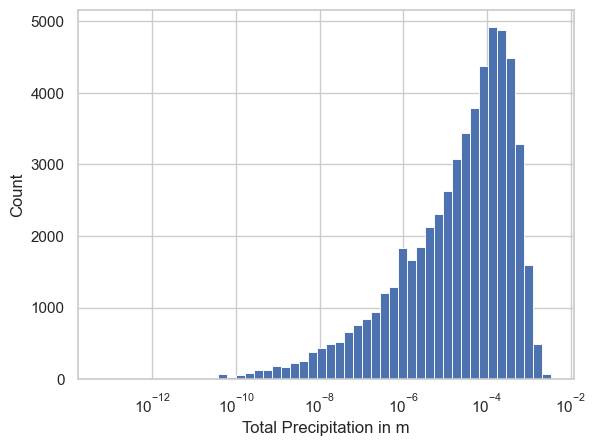

In [35]:
ax = sns.histplot(
    data=era5_data["tp"], legend=False, log_scale=(True, False), alpha=1.0, bins=50
)

ax.set_xlabel("Total Precipitation in m");

Plotting the data after excluding 0 values it becomes evident that most of the values are within a range of $10^{-6}$ to around $10^{-2}$ eg. are range of 0.001 mm to 10 mm over the total area of austria.

# Analysis of the Zonal wind component

Description:

Eastward component of the 10m wind. It is the horizontal speed of air moving towards the east, at a height of ten metres above the surface of the Earth, in metres per second. Care should be taken when comparing this variable with observations, because wind observations vary on small space and time scales and are affected by the local terrain, vegetation and buildings that are represented only on average in the ECMWF Integrated Forecasting System. This variable can be combined with the V component of 10m wind to give the speed and direction of the horizontal 10m wind.

Source: https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels?tab=overview

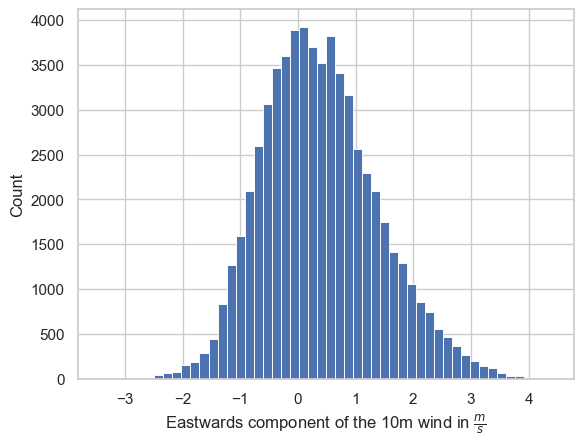

In [36]:
ax = sns.histplot(
    data=era5_data["u10"],
    legend=False,
    log_scale=False,
    alpha=1.0,
    bins=50,
)

ax.set_xlabel("Eastwards component of the 10m wind in $\\frac{m}{s}$");

The overall averaged sum of east-west wind seems to be fairly normal distrubuted in the range of 4 $\frac{m}{s}$ to 3 $\frac{m}{s}$.  

# Analysis of the Meridional wind component

Description:

Northward component of the 10m wind. It is the horizontal speed of air moving towards the north, at a height of ten metres above the surface of the Earth, in metres per second. Care should be taken when comparing this variable with observations, because wind observations vary on small space and time scales and are affected by the local terrain, vegetation and buildings that are represented only on average in the ECMWF Integrated Forecasting System. This variable can be combined with the U component of 10m wind to give the speed and direction of the horizontal 10m wind.

Source: https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land?tab=overview

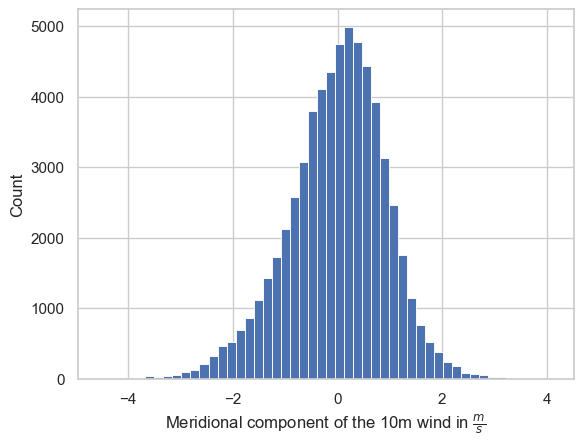

In [37]:
ax = sns.histplot(
    data=era5_data["v10"], legend=False, log_scale=False, alpha=1.0, bins=50
)

ax.set_xlabel("Meridional component of the 10m wind in $\\frac{m}{s}$");

The overall country averaged sum of south-north wind seems to be in the same range as the zonal wind component (4 $\frac{m}{s}$ to 3 $\frac{m}{s}$).  

# Multivaraite analysis

First we prepare a dataframe with the required variables and the actua total load to analyse in the next steps. In this part of the EDA the hourly mean total load is used, because we want to analyze the relationship between the target and the variables and in this format we don't have to interpolate the data.

In [38]:
# Build a dataframe for the correlation calculation
data_combined = df_hourly.copy()
data_combined.index = data_combined.index.tz_localize("UTC")

# Prepare Names the names for the columns
for var in era5_variables:
    era5_var = era5_data[var].rename(columns={"value": var})

    if isinstance(era5_var.index, pd.PeriodIndex):
        era5_var.index = era5_var.index.to_timestamp()
        era5_var.index = era5_var.index.tz_localize("UTC")

    data_combined = data_combined.join(era5_var)

# Get the average wind speed
data_combined["wind_speed"] = np.sqrt(
    data_combined["u10"] ** 2 + data_combined["v10"] ** 2
)
data_combined.drop(columns=["u10", "v10"], inplace=True)

# Get the solar irridiation in W/m^2
data_combined["ssrd"] = data_combined["ssrd"] / 3600


# Get the solar irridiation in °C
data_combined["t2m"] = data_combined["t2m"] - 273.15

# Add seasons for plotting
month = data_combined.index.month

conditions = [
    (month.isin([12, 1, 2])),
    (month.isin([3, 4, 5])),
    (month.isin([6, 7, 8])),
    (month.isin([9, 10, 11])),
]
choices = ["Winter", "Spring", "Summer", "Autumn"]

data_combined["season"] = np.select(conditions, choices, default="Unknown")

In [91]:
sampled = data_combined.sample(frac=0.2, random_state=1234)

# Load against temperature

In this series of plots the bivariate data of the actual total load and the different predictors are plotted to evaluate their relationship.

Text(0.5, 0.01, 'Temperature (°C)')

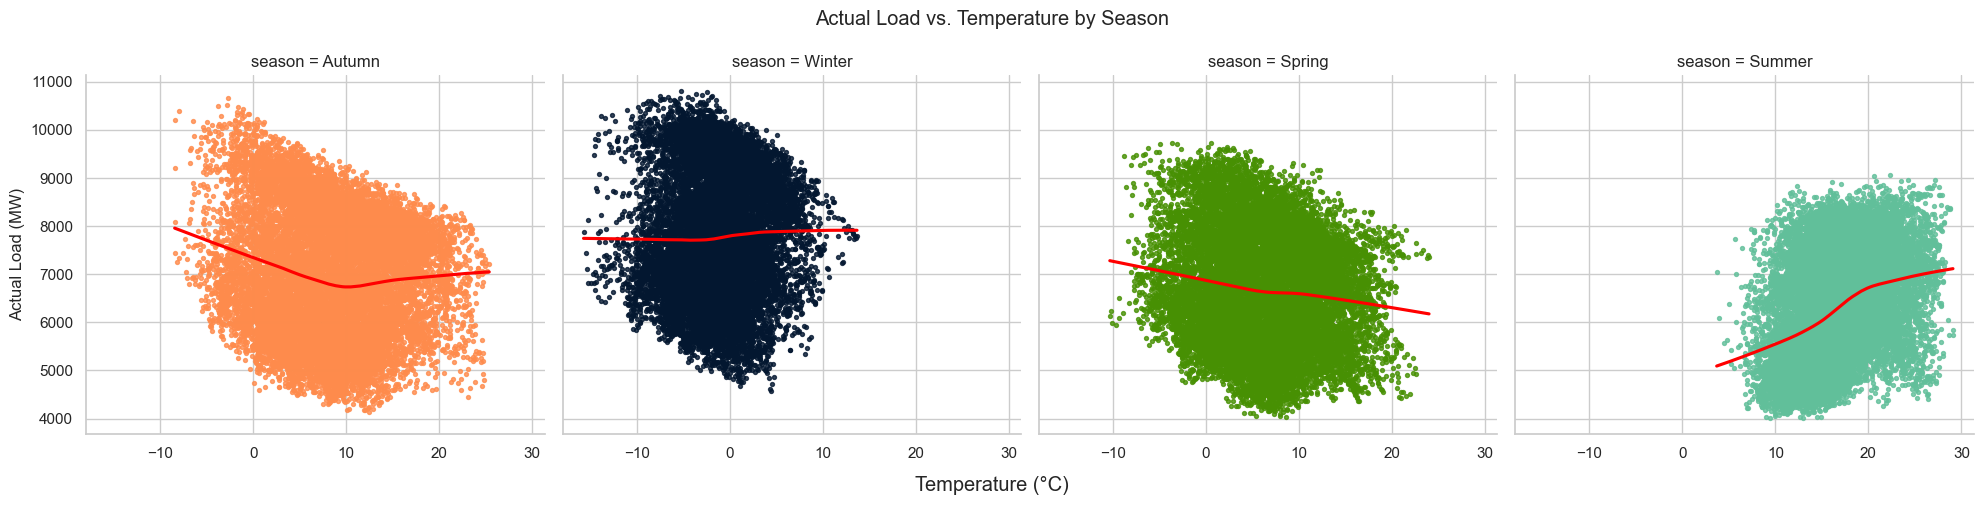

In [ ]:
p = sns.lmplot(
    data=data_combined,
    x="t2m",
    y="actual_load_mw",
    col="season",
    hue="season",
    scatter_kws={"alpha": 0.2, "s": 8},
    line_kws={"color": "red"},
    lowess=True,
    palette=season_colors
)

p.set_axis_labels("", "Actual Total Load (MW)")
p.figure.subplots_adjust(top=0.85)
p.figure.suptitle("Actual Total Load vs. Temperature by Season")
p.figure.supxlabel("Temperature (°C)");

We can see that there appears to be different relations. The load seems to be slowly declining as the temperature increases. In contrast, during summer the load seems to rise, perhaps due to multiple factors like increased AC usage or agricultural acticity . In winter, the load remains fairly constant across temperature values but at a higher total average. Lastly, the load values in autumn decline for higher temperature values as this could be linked to less heating demand.

# Load against solar radiation downwards

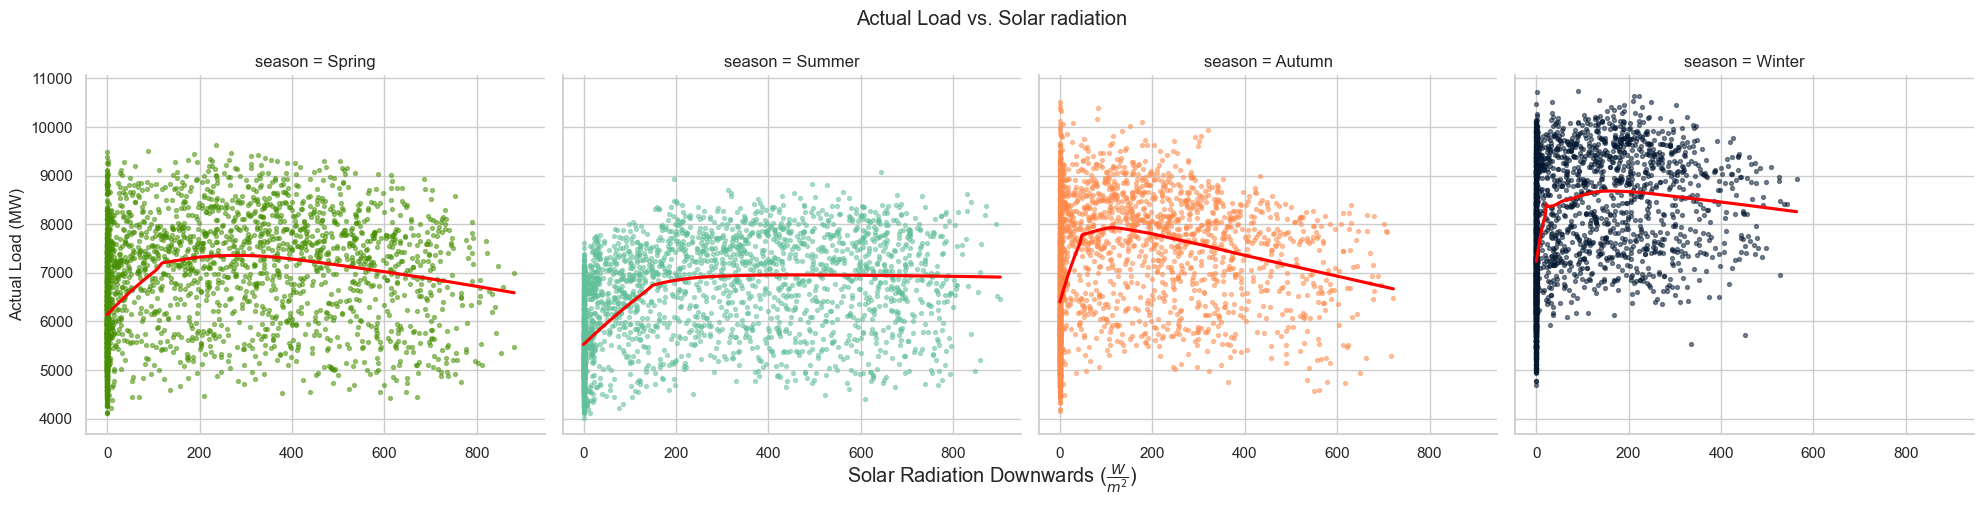

In [ ]:
p = sns.lmplot(
    data=data_combined,
    x="ssrd",
    y="actual_load_mw",
    col="season",
    hue="season",
    scatter_kws={"alpha": 0.2, "s": 8},
    line_kws={"color": "red"},
    lowess=True,
    palette=season_colors
)
p.set_axis_labels("", "Actual Total Load (MW)")
p.figure.subplots_adjust(top=0.85)
p.figure.suptitle("Actual Total Load vs. Solar radiation")
p.figure.supxlabel("Solar Radiation Downwards ($\\frac{W}{m^2}$)");

We can see that there are some non-linear relationships. As there are many observations during the night, where the solar radiation is 0, many observations also tend to cluster near 0. The summer season appears to be the only season where the total load seems to rise from the lower nightly values towards a steady value around 7000 MW. In comparison, the other seasons show decline of the load after a more distinct initial peek. 

The pattern of initially rising load could be influenced by the increased need for electric energy during colder and darker morning and evening hours for lighting and heating. While in summer daylight is available longer and there is no increased heating demand, which explain why there is no distinctive peak. The abscence of a decline in load during summer even with more solar radiation could stem from more AC usage in those days.

Notably, the load in the winter is higher than in the rest of the seasons while there are not as many high solar radiance measurments as in the rest of the seasons.

# Load against Windspeed

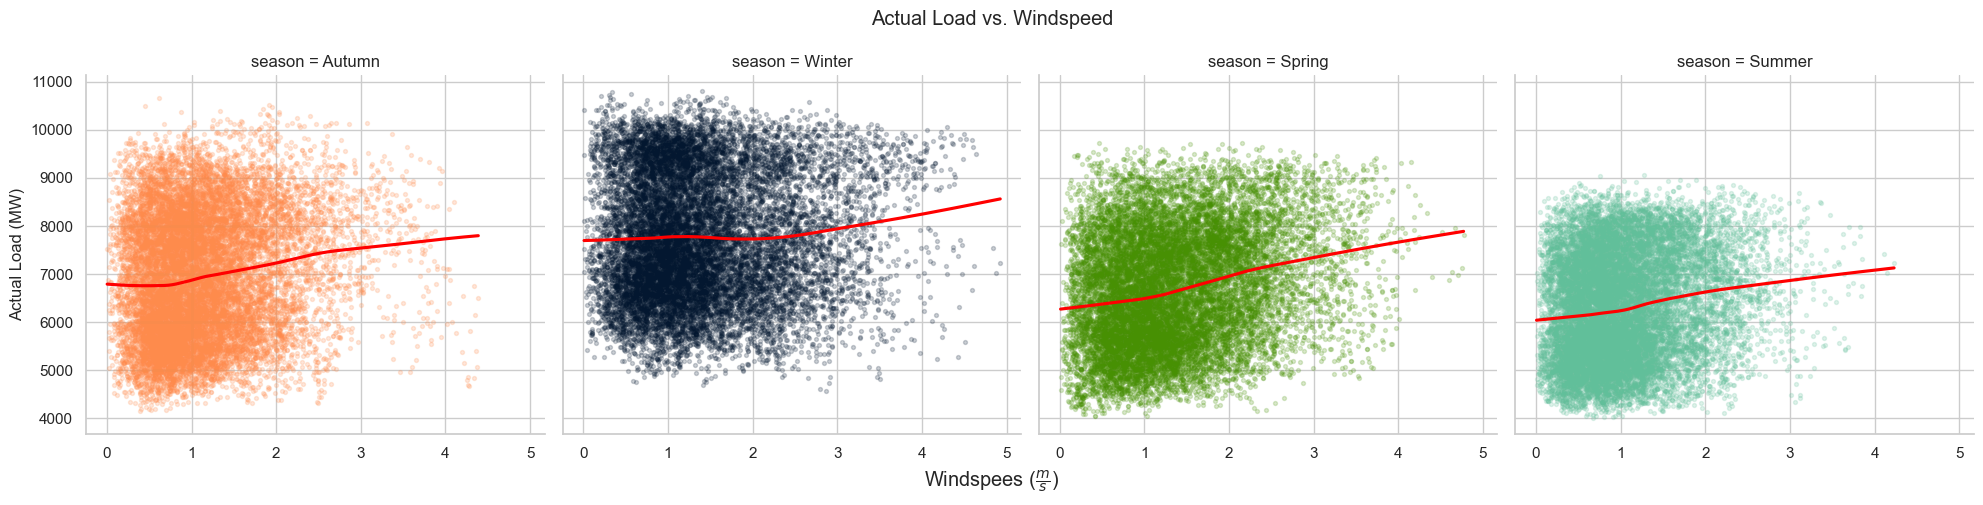

In [ ]:
p = sns.lmplot(
    data=data_combined,
    x="wind_speed",
    y="actual_load_mw",
    col="season",
    hue="season",
    scatter_kws={"alpha": 0.35, "s": 8},
    line_kws={"color": "red"},
    lowess=True,
    palette=season_colors
)
p.set_axis_labels("", "Actual Total Load (MW)")
p.figure.subplots_adjust(top=0.85)
p.figure.suptitle("Actual Total Load vs. Windspeed")
p.figure.supxlabel("Windspeed ($\\frac{m}{s}$)");

There is an interessting relation of wind total load and wind, the load seems to increase togheter with higher wind speeds. Of course not interpreting apart from the far outliers of wind speeds up around four to five meters per second which make the loess fit less stable.

This relationship is likely coincidental rather than causal, as higher windspeeds are often associated with cold fronts that bring lower temperatures. These conditions increase heating demand and thereby raise the overall electricity load.

# Load against total precipitation

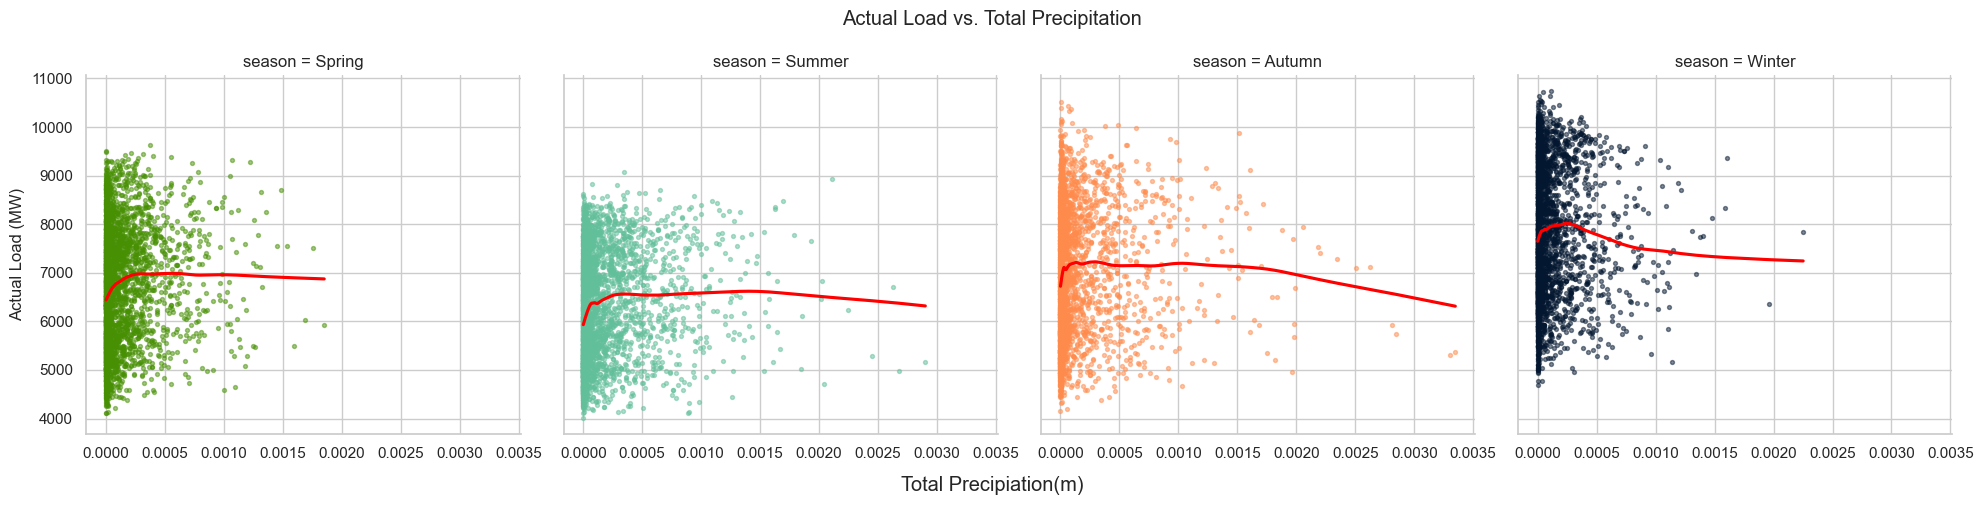

In [ ]:
p = sns.lmplot(
    data=sampled,
    x="tp",
    y="actual_load_mw",
    col="season",
    hue="season",
    scatter_kws={"alpha": 0.5, "s": 8},
    line_kws={"color": "red"},
    lowess=True,
    palette=season_colors
)

p.set_axis_labels("", "Actual Total Load (MW)")
p.figure.subplots_adjust(top=0.85)
p.figure.suptitle("Actual Total Load vs. Total Precipitation")
p.figure.supxlabel("Total Precipiation(m)");

The plot does not reveal an clear relationship between actual total load and the country-averaged precipitation. It appears that the highest records of precipitation do occur during autumn, which was expected. As the LOESS fit becomes more unstable for extreme values, the curve should be interpreted up to around 0.0010 m of precipitation.

Overall, there appears to be an increase of load when the precipitation goes from 0 to 0.0005 m, however this relation is, like the wind data, reflecting the influence of weather conditions rather than precipitation itself. Periods of heavier rain are often associated with colder, darker and unpleasant weather which can load people to stay indoors and thus increase electricity demand.

# Pairwise comparison of the features

The following plot aims to reveal the general relationship between the variables and is a preliminary to investigate possible multicoliniarity before performing a formal multicolinearity test.

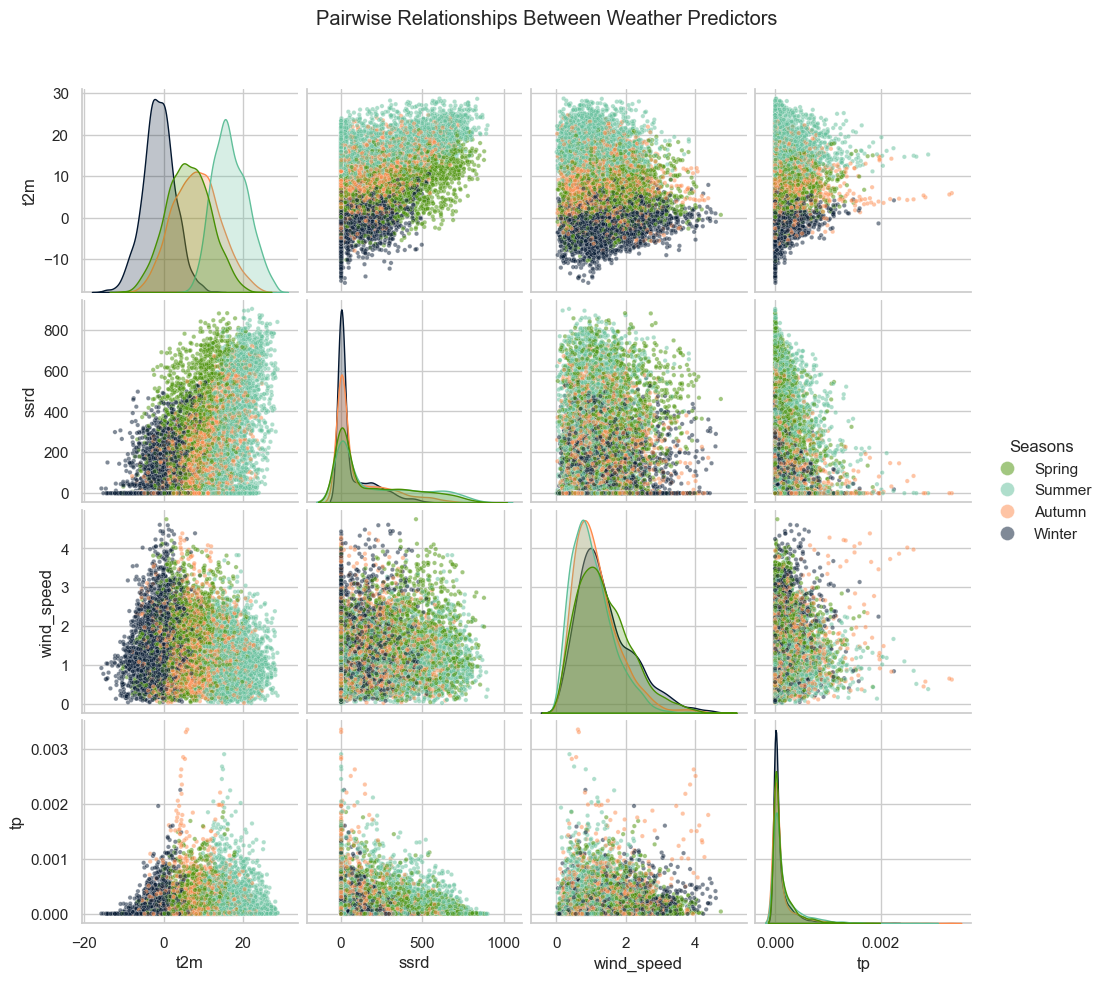

In [136]:
p = sns.pairplot(
    data=sampled,
    vars=["t2m", "ssrd", "wind_speed", "tp"],
    hue="season",
    plot_kws={"alpha": 0.5, "s": 10},
    diag_kind="kde",
    corner=False,
    palette=season_colors
);

p.figure.suptitle("Pairwise Relationships Between Weather Predictors")
p.figure.subplots_adjust(top=0.9)

if p.legend:
    p.legend.set_title("Seasons")
    for lh in p.legend.legend_handles:
        lh.set_markersize(10)  # type: ignore[attr-defined]

The diagonal kernel density plots show the distribution of each variable stratified by season.As expected, temperature distributions shift toward lower values in winter and higher values in summer, with spring and autumn exhibiting overlapping ranges.


Solar ratiation exhibits a pronounced seasonal pattern with higher and more frequent values during spring and summer and considerably lower values during winter and autumn.

Wind speed distributions are relatively consistent across seasons with slightly higher averages observed in winter and spring. Precipitation shows minimal seasonal variation in its overall distribution although lowever percipitation is more likely during winter.

Assessing the pairwise relationships, temperature and solar radiation display a strong positive association, consistent with seasonal and diurnal heating effects. In contrast, wind speed is negatively associated with temperature, reflecting the presence of colder, windier weather systems.

Precipitation shows no clear dependency on temperature, although slightly higher precipitation levels occur during summer and autumn months.

Wind speed and solar radiation appear largely uncorrelated. However, the frequency of high-precipitation events decreases with increasing solar radiation, as cloudy or stormy conditions naturally limit incoming sunlight.

Finally, the relationship between wind speed and total precipitation suggests a slight decrease in precipitation at higher wind speeds. This may reflect the limited number of high-wind observations in the dataset, which reduces the representativeness of precipitation levels under such conditions.

# Correlations

Next, Pearson correlations are calculated to assess the strength and direction of linear relationships among the variables.

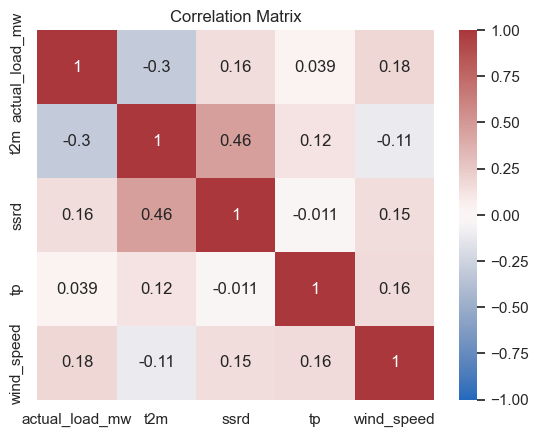

In [107]:
ax = sns.heatmap(data=data_combined.select_dtypes(np.number).corr(), vmin=-1, vmax=1, cmap="vlag", annot=True);

ax.set_title("Correlation Matrix");

The values in this plot represent the correlations of the raw time series. These may reflect genuine relationships between variables or merely spurious correlations arising from shared trends or seasonal effects.

To further investigate potential lead–lag relationships and temporal dependencies between the variables, the cross-correlation function (CCF) is applied in the next step.

In [151]:
from statsmodels.tsa.stattools import ccf


def get_ccf_plot(x, y, era_5_var: str, ax, max_lag=7 * 24):
    """Plot the cross-correlation plot for a era5 variable and the actual total load target"""

    cross_corr, confint = ccf(x=x, y=y, nlags=max_lag, alpha=.05)
    lags = np.arange(max_lag)

    ax.bar(lags, cross_corr, width=0.8)
    ax.fill_between(lags, confint[:, 0], confint[:, 1], color="red", alpha=1, zorder=0)
    ax.axhline(0, color="black", lw=1)
    ax.set_title(f"CCF: Total Load vs {era_5_var}\n(+lag: {era_5_var} leads)")
    ax.set_xlabel("Lag (hours)")
    ax.set_ylabel("Correlation coefficient")

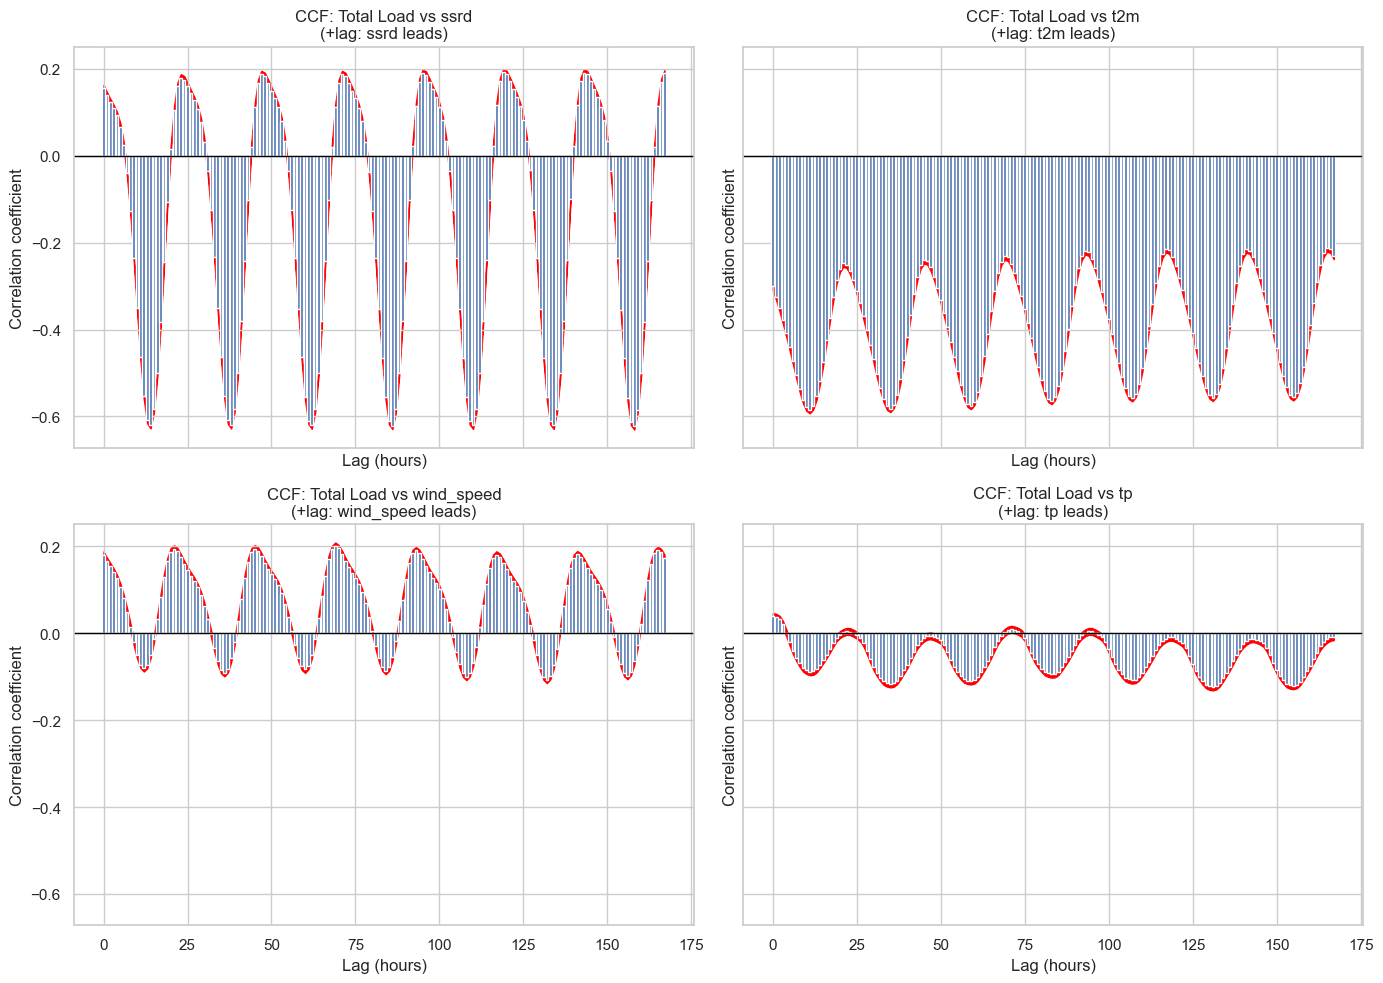

In [152]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)

era5_vars = ["ssrd", "t2m", "wind_speed", "tp"]

x = data_combined["actual_load_mw"].dropna()

for ax, var in zip(axes.flatten(), era5_vars):
    y = data_combined[var].dropna()
    get_ccf_plot(x=x, y=y, era_5_var=var, ax=ax, max_lag=7 * 24)

plt.tight_layout()

To explore whether variations in the meteorological variables precede changes in total load, cross-correlation functions (CCFs) were first computed on the raw time series. The resulting plots show a strong periodic pattern, indicating that the apparent correlations are primarily driven by shared diurnal and seasonal cycles rather than genuine lead–lag relationships. As none of the correlation coefficients lie outside the confidence bounds, there is no statistically significant linear correlation beyond these common seasonal effects.

To identify the true relationships between the variables, both series must therefore be detrended and deseasonalized, so that the resulting correlations reflect dynamic dependencies rather than coincident seasonal components.

## Are there correlations extreme events/in the residulals?

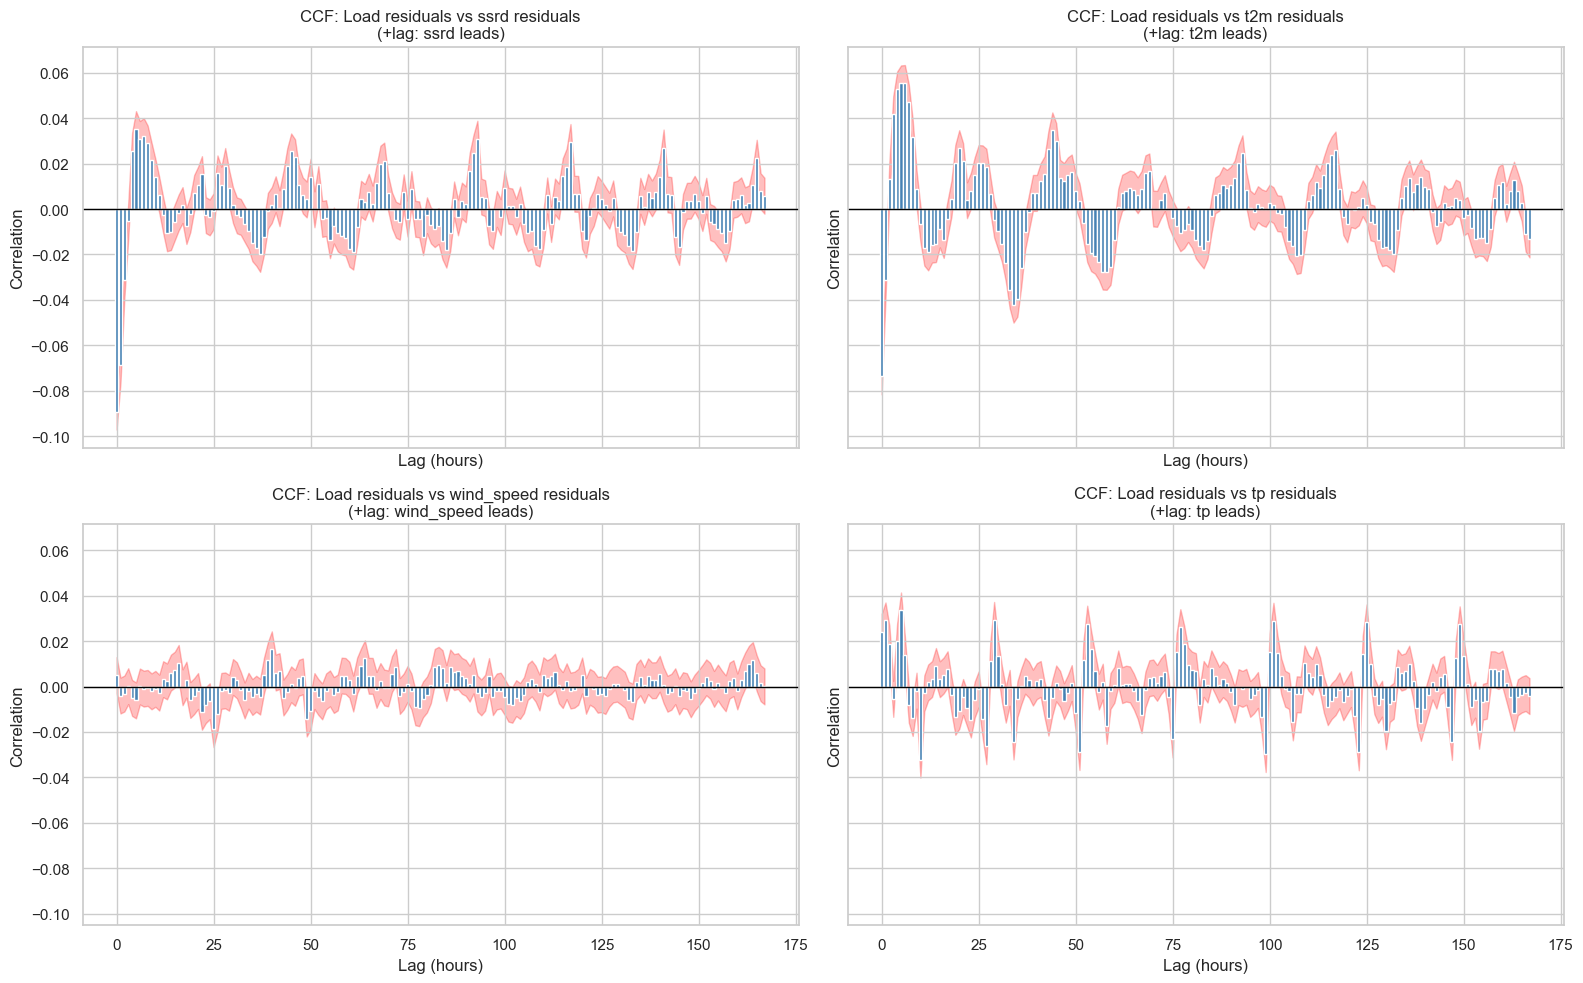

In [148]:
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA

def stl_residuals(s: pd.Series, period=24) -> pd.Series:
    """Deseasonalize & detrend via STL; return residuals (no edge NaNs)."""
    stl = STL(s, period=period, robust=True).fit()
    return stl.resid.dropna()


def prewhiten(resid: pd.Series, ar_order=1) -> pd.Series:
    """Remove remaining short-memory autocorr with a small AR model; return residuals."""
    model = ARIMA(resid, order=(ar_order, 0, 0)).fit(
        method_kwargs={"warn_convergence": False}
    )
    return model.resid.dropna()


def prepared_residuals(s: pd.Series, period=24) -> pd.Series:
    """STL residuals + AR(1) prewhitening, ready for CCF."""
    return prewhiten(stl_residuals(s, period=period))


def plot_ccf_on_ax(
    ax,
    target_resid: pd.Series,
    pred_resid: pd.Series,
    max_lag=7 * 24,
    alpha=0.05,
    title="",
):
    """
    Plot CCF on a provided Axes.
    We call ccf(x=pred, y=target) so POSITIVE lags mean predictor leads target.
    """
    # Align so we correlate the same timestamps
    x, y = target_resid.align(pred_resid, join="inner")  # x=target (load), y=predictor
    if len(x) == 0:
        ax.set_title(f"{title}\n(no overlap)")
        return ax

    if alpha is None:
        vals = ccf(x=x, y=y, nlags=max_lag)
        conf = None
    else:
        vals, conf = ccf(x=x, y=y, nlags=max_lag, alpha=alpha)

    lags = np.arange(max_lag)
    ax.bar(lags, vals, width=0.8, color="steelblue")
    ax.axhline(0, color="black", lw=1)

    if conf is not None:
        ax.fill_between(lags, conf[:, 0], conf[:, 1], color="red", alpha=0.25, zorder=0)

    ax.set_title(title or "CCF")
    ax.set_xlabel("Lag (hours)")
    ax.set_ylabel("Correlation")
    return ax


# Prepare residuals for the TARGET once
x_resid = prepared_residuals(data_combined["actual_load_mw"], period=24)

# Variables to compare against the target
era5_vars = ["ssrd", "t2m", "wind_speed", "tp"]

# Faceted CCFs
fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharex=True, sharey=True)

for ax, var in zip(axes.flatten(), era5_vars):
    y_resid = prepared_residuals(data_combined[var], period=24)
    plot_ccf_on_ax(
        ax=ax,
        target_resid=x_resid,
        pred_resid=y_resid,
        max_lag=7 * 24,
        alpha=0.05,
        title=f"CCF: Load residuals vs {var} residuals\n(+lag: {var} leads)",
    )

plt.tight_layout()
plt.show()

The main goal of computing the lagged correlations for the variables leading load after being detrended, deseasonalized and autoregression removed was to find if the residuals of both timeseries are linearly correlated. In other words, I wanted to see whether an unexpected deviation in a weather variable leads to a corresponding delayed response in the load, beyond what is already explained by seasonal and trend effects.

As the plot above shows this is not the case, the correlation values are all within the confidence intervales eg. none is being significant. This indicates that once the common seasonal and trend components are removed, the residuals of the weather variables and the load are not correlated and the short-term fluctuations of weather do not systematically drive the short-term fluctuations of load.

Consequently, the observed relationships between load and weather are largely explained by seasonal effects and no lagged versions of the weather variables are needed in the forecasting model. While the cross-correlation function did not show statistically significant coefficients at any lag, the strong visual and physical correspondence between load and weather variables indicates that these factors contribute to the systematic seasonal variation in load. The lack of significant residual correlation simply confirms that no additional short-term linear dependence remains once this structure is modeled.

# Check if there is Multicolinearity

There were some possible correlations identified in the pairplot earlier. A formal test for multicollinearity is therefore conducted using the Variance Inflation Factor (VIF) to quantify the extent of linear dependency among the predictors. Variables with a VIF value exceeding 5 are typically considered to exhibit problematic multicollinearity, as they provide redundant information.

In [108]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = data_combined[era5_vars]
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

,Variable,VIF
0,ssrd,1.537854
1,t2m,4.190195
2,wind_speed,4.019941
3,tp,1.331330


There seems to be no multicolinearity between the variables which mean all of them can be considered for modelling in the next steps.

# Holiday features

In [179]:
import holidays

# Get holidays in austria
years = range(data_combined.index.min().year, data_combined.index.max().year + 1)
at_holidays = holidays.country_holidays("AT", years=years)

# Add columns holiday_name and is_holiday
data_combined["holiday_name"] = data_combined.index.map(lambda x: at_holidays.get(x, None))
data_combined["is_holiday"] = data_combined["holiday_name"].notna()

# Verify
data_combined["holiday_name"].describe()

count                 2184
unique                  13
top       Nationalfeiertag
freq                   168
Name: holiday_name, dtype: object

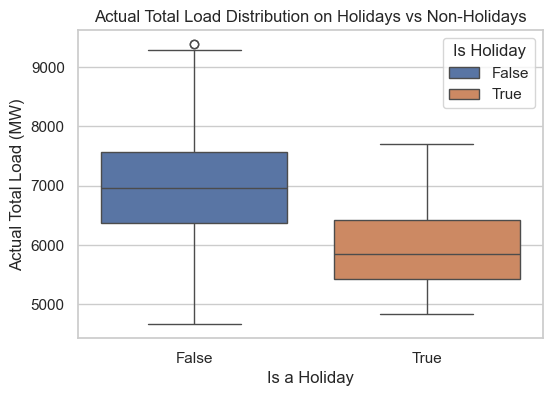

In [196]:
daily = data_combined.resample("D")["actual_load_mw"].mean().to_frame()
daily["is_holiday"] = data_combined["is_holiday"].resample("D").max()

plt.figure(figsize=(6, 4))
sns.boxplot(
    data=daily,
    x="is_holiday",
    y="actual_load_mw",
    hue="is_holiday"
)

plt.title("Actual Total Load Distribution on Holidays vs Non-Holidays")
plt.xlabel("Is a Holiday")
plt.ylabel("Actual Total Load (MW)")
plt.legend(title="Is Holiday");

The boxplot illustrates clear structural differences in electricity demand between holidays and non-holidays.

The median total load on holidays is markedly lower around 6000 MW compared to roughly 7000 MW on regular days which indicates a consistent drop of about 1 GW in demand.

The narrower interquartile range on holidays suggests more uniform consumption patterns, while the broader and higher spread on non-holiday days reflects greater variability and higher peak loads typical of working days and weekends. This shift in the entire distribution demonstrates that holidays systematically reduce demand levels. For modeling purposes, this effect should be explicitly captured through a holiday indicator variable.

To measure if the difference between the to medians of the groups is significant, a Mann–Whitney U is employed.

$$
H_0:\tilde{x}_{holiday} = \tilde{x}_{non\_holiday} \\
H_1:\tilde{x}_{holiday} \ne \tilde{x}_{non\_holiday}
$$

In [199]:
from scipy.stats import mannwhitneyu

holiday_loads = daily.loc[daily["is_holiday"], "actual_load_mw"]
nonholiday_loads = daily.loc[~daily["is_holiday"], "actual_load_mw"]

u_stat, p_val = mannwhitneyu(holiday_loads, nonholiday_loads, alternative="two-sided")
print(f"U = {u_stat:.2f}, p = {p_val:.4f}")

U = 43882.00, p = 0.0000


A Mann–Whitney U test was conducted to assess whether the median electricity load differs between holidays and non-holidays. With a p-value smaller than 0.05 the null hypothesis is rejected indicating a statistically significant difference in the load distributions between the two groups. This confirms that electricity demand on holidays is systematically lower and follows a different distribution than on regular days.